In [76]:
### Extra code to reuse

## Exporting data to CSV
# combined_data.to_csv('file_name.csv')

## Finding what the Data Type a column is.
# data_type = IMDb_Basics['isAdult'].dtype
# print(data_type)

## Filtering dataframes for a specific values
# filtered_df = IMDB_Basics[IMDB_Basics['primaryTitle'].str.contains('Bond', case=False, na=False)]
# print(filtered_df)

# Optionally save the combined dataframe to a new CSV file
# output_file = path_to_files + 'combined_data.csv'
# combined_df.to_csv(output_file, index=False)
# print(f"Combined CSV saved to {output_file}")

# Code to troubleshoot date columns

# 1. Check for NaT values:
# If you used errors='coerce' during the conversion, you can check for NaT values, which would indicate conversion failures.
# nat_counts = all_stocks['Date'].isna().sum()
# print(f"Number of NaT values in 'Date': {nat_counts}")

# 2. Check the range of dates:
# Look at the minimum and maximum values to ensure they are within expected bounds.
# print("Earliest date:", all_stocks['Date'].min())
# print("Latest date:", all_stocks['Date'].max())

# 3. Sample random dates:
# Random sampling of dates can give you a quick spot check to see if dates look correctly formatted.
# print(all_stocks['Date'].sample(10))

# 4. Validate with known dates:
# If you know certain dates should exist in the dataset, check those specifically.
# known_dates = ["1997-05-15", "2005-07-08"]  # Example dates you expect to find
# for date in known_dates:
#     if pd.to_datetime(date) not in all_stocks['Date'].values:
#         print(f"Date {date} is not found or incorrectly formatted.")
#     else:
#         print(f"Date {date} is correctly formatted.")

# 5. Check for duplicates:
# Ensuring that there are no duplicate dates which could suggest an issue with the conversion.
# duplicate_dates = all_stocks['Date'].duplicated().sum()
# print(f"Number of duplicate dates: {duplicate_dates}")

## Remove duplicate rows based on the 'Release' column, keeping the first occurrence
# no_duplicates = no_duplicates.drop_duplicates(subset='Release', keep='first')

# # Remove the dollar sign and commas, then convert the column to numeric values
# no_duplicates['Gross'] = no_duplicates['Gross'].replace(r'[\$,]', '', regex=True).astype(float)
# # Calculate the mean of the 'Gross' column after conversion
# gross_mean = no_duplicates['Gross'].mean()
# # Now 'gross_mean' contains the average of the 'Gross' column as a float
# print(gross_mean)

<span style="color:green">

# Meeting notes

## Meeting 1 Feedback- In-Progress
Project Proposal Meeting notes
 Outcome variable is Stock returns
We cannot have 2 different observations we could use weighted average or just an average of the 2 movies. Because in a month there could be 2 movies launched by Disney and we need to be able to see what is the causal but with just 1 movie.
We should do quarterly and then do monthly. So this way we will be able to see a change in the response from investors and the market.
I will determine the number of years of data according to the number of observations.
(I can include Text analysis based on individual people’s reviews for each movies. I can use this for my Capstone project. I can do analysis on if someone left a good review score and bad text comments.)

## Meeting 2 Feedback- 

</span>

<span style="color:red">

# Problems to be solved

1. For the economic indicators the data spans for each quarter in a year and not monthly. What do we do about that?

</span>

# Setting File location

In [3]:
import os
import glob
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

os.chdir('/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/MSEA/ECON 5813 - Economic Analytics I/Project Proposal/Data')

---------------

# 1. Loading and Modeling Stocks Data

In [78]:
# 1: Stocks
Amazon_Stock = pd.read_csv('Amazon Stock.csv')
Apple_Stock = pd.read_csv('Apple Stock.csv')
ATT_Stock = pd.read_csv('AT&T Stock.csv')
Comcast_Stock = pd.read_csv('Comcast Stock.csv')
Lions_Gate_Historical_B = pd.read_csv('Lions Gate Historical.csv')
Netflix_Stock_Data = pd.read_csv('Netflix Stock Data.csv')
Paramount_Global_Historical_Prices = pd.read_csv('Paramount Global Historical Prices.csv')
Sony_Stock = pd.read_csv('Sony Stock.csv')
The_Walt_Disney_Company_Historical_Prices = pd.read_csv('The Walt Disney Company Historical Prices.csv')
Warner_Bros_Discovery = pd.read_csv('Warner Bros Discovery.csv')
Vanguard_500_Historical = pd.read_csv('Vanguard 500 Historical.csv')

In [79]:
# Adding company to each individual stick dataframe to the respective company name.
Amazon_Stock['Company'] = 'Amazon'
Apple_Stock['Company'] = 'Apple'
ATT_Stock['Company'] = 'AT&T'
Comcast_Stock['Company'] = 'Comcast'
Lions_Gate_Historical_B['Company'] = 'Lions Gate'
Netflix_Stock_Data['Company'] = 'Netflix'
Paramount_Global_Historical_Prices['Company'] = 'Paramount Global'
Sony_Stock['Company'] = 'Sony'
The_Walt_Disney_Company_Historical_Prices['Company'] = 'Walt Disney'
Warner_Bros_Discovery['Company'] = 'Warner Bros Discovery'
Vanguard_500_Historical['Company'] = 'Vanguard_500_Historical'

# Convert 'Date' columns to datetime for all dataframes before merging
# Note: If your date formats are inconsistent, you may need to handle them individually.
company_stocks = [Amazon_Stock, Apple_Stock, ATT_Stock, Comcast_Stock, Lions_Gate_Historical_B, Netflix_Stock_Data, Paramount_Global_Historical_Prices, Sony_Stock, The_Walt_Disney_Company_Historical_Prices, Warner_Bros_Discovery, Vanguard_500_Historical]

for stock_df in company_stocks:
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Define the list of company names
company_names = ['Amazon', 'Apple', 'AT&T', 'Comcast', 'Lions Gate', 'Netflix', 'Paramount Global', 'Sony', 'Walt Disney', 'Warner Bros Discovery', 'Vanguard 500']

# Initialize the combined DataFrame
all_stocks = pd.DataFrame()

# Loop through each company DataFrame
for stock_df, company_name in zip(company_stocks, company_names):
    # Rename columns to include the company name (excluding 'Date')
    cols_to_rename = {col: f"{col}_{company_name}" for col in stock_df.columns if col != 'Date'}
    df_renamed = stock_df.rename(columns=cols_to_rename)
    
    # Merge with the combined DataFrame
    if all_stocks.empty:
        all_stocks = df_renamed
    else:
        all_stocks = all_stocks.merge(df_renamed, on='Date', how='outer')

# all_stocks now contains all the data with renamed columns and one 'Date' column
all_stocks.sort_values('Date', inplace=True)

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_65373/1036042635.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])


In [80]:
# Formatting the date column to the appropriate date type.
def parse_dates(date):
    for fmt in ("%Y-%m-%d", "%m/%d/%y"):  # Add or adjust formats as needed
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # return Not a Time for unparseable formats

all_stocks['Date'] = all_stocks['Date'].apply(parse_dates)

In [81]:
# # Code to check basic information about a table

# # all_stocks.info()

# all_stocks.dtypes[6]

# all_stocks.isnull().sum()

# all_stocks.isnull().mean()

# all_stocks.nunique()

# all_stocks.value_counts()

# all_stocks.memory_usage(deep=True)

#Descriptive Statistics for All Stocks.
print(all_stocks.describe())

                                Date  Open_Amazon  High_Amazon   Low_Amazon  \
count                          15554  6648.000000  6648.000000  6648.000000   
mean   1992-12-01 11:34:37.973511680    33.465443    33.868688    33.026142   
min              1962-01-02 00:00:00     0.070313     0.072396     0.065625   
25%              1977-07-12 06:00:00     2.022719     2.063875     1.989750   
50%              1992-11-26 00:00:00     6.857250     6.960000     6.766000   
75%              2008-05-05 18:00:00    42.573249    42.694751    42.343500   
max              2023-10-16 00:00:00   187.199997   188.654007   184.839493   
std                              NaN    49.394337    49.975037    48.752435   

       Close_Amazon  Adj Close_Amazon  Volume_Amazon    Open_Apple  \
count   6648.000000       6648.000000   6.648000e+03  10800.000000   
mean      33.454436         33.454436   1.408481e+08     19.244714   
min        0.069792          0.069792   9.744000e+06      0.049665   
25%     

In [82]:
all_stocks.tail(10)

,Date,Open_Amazon,High_Amazon,Low_Amazon,Close_Amazon,Adj Close_Amazon,Volume_Amazon,Company_Amazon,Open_Apple,High_Apple,...,Adj Close_Warner Bros Discovery,Volume_Warner Bros Discovery,Company_Warner Bros Discovery,Open_Vanguard 500,High_Vanguard 500,Low_Vanguard 500,Close_Vanguard 500,Adj Close_Vanguard 500,Volume_Vanguard 500,Company_Vanguard 500
6639,2023-10-03,128.059998,128.520004,124.250000,124.720001,124.720001,51565000.0,Amazon,172.259995,173.630005,...,10.35,20757100.0,Warner Bros Discovery,390.579987,391.929993,386.029999,387.390015,387.390015,6886700.0,Vanguard_500_Historical
6640,2023-10-04,126.059998,127.360001,125.680000,127.000000,127.000000,44203900.0,Amazon,171.089996,174.210007,...,10.29,17845200.0,Warner Bros Discovery,387.730011,390.850006,386.399994,390.239990,390.239990,4333700.0,Vanguard_500_Historical
6641,2023-10-05,126.709999,126.730003,124.330002,125.959999,125.959999,39660600.0,Amazon,173.789993,175.449997,...,10.09,22760300.0,Warner Bros Discovery,389.890015,390.790009,386.950012,389.910004,389.910004,3329100.0,Vanguard_500_Historical
6642,2023-10-06,124.160004,128.449997,124.129997,127.959999,127.959999,46795900.0,Amazon,173.800003,177.990005,...,10.28,21040300.0,Warner Bros Discovery,387.690002,396.089996,386.410004,394.559998,394.559998,4896100.0,Vanguard_500_Historical
6643,2023-10-09,126.220001,128.789993,124.760002,128.259995,128.259995,38773700.0,Amazon,176.809998,179.050003,...,10.53,15518600.0,Warner Bros Discovery,392.769989,397.690002,392.309998,397.190002,397.190002,2959500.0,Vanguard_500_Historical
6644,2023-10-10,128.820007,130.740005,128.050003,129.479996,129.479996,42178600.0,Amazon,178.100006,179.720001,...,10.67,26641800.0,Warner Bros Discovery,397.769989,401.679993,397.390015,399.239990,399.239990,3289600.0,Vanguard_500_Historical
6645,2023-10-11,129.740005,132.050003,129.610001,131.830002,131.830002,40741800.0,Amazon,178.199997,179.850006,...,10.96,18216200.0,Warner Bros Discovery,400.269989,401.089996,397.989990,400.929993,400.929993,4181800.0,Vanguard_500_Historical
6646,2023-10-12,132.169998,134.479996,131.229996,132.330002,132.330002,55528600.0,Amazon,180.070007,182.339996,...,10.32,14748400.0,Warner Bros Discovery,401.480011,401.799988,396.200012,398.519989,398.519989,3872900.0,Vanguard_500_Historical
6647,2023-10-13,132.979996,133.309998,128.949997,129.789993,129.789993,45786600.0,Amazon,181.419998,181.929993,...,10.37,15401300.0,Warner Bros Discovery,399.809998,400.959991,394.959991,396.420013,396.420013,3769800.0,Vanguard_500_Historical
10988,2023-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
all_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15554 entries, 12775 to 10988
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             15554 non-null  datetime64[ns]
 1   Open_Amazon                      6648 non-null   float64       
 2   High_Amazon                      6648 non-null   float64       
 3   Low_Amazon                       6648 non-null   float64       
 4   Close_Amazon                     6648 non-null   float64       
 5   Adj Close_Amazon                 6648 non-null   float64       
 6   Volume_Amazon                    6648 non-null   float64       
 7   Company_Amazon                   6648 non-null   object        
 8   Open_Apple                       10800 non-null  float64       
 9   High_Apple                       10800 non-null  float64       
 10  Low_Apple                        10800 non-null  float64   

In [84]:
# Use the provided parse_dates function to convert dates
all_stocks['Date'] = all_stocks['Date'].apply(parse_dates)

# Now set 'Date' as the index
all_stocks.set_index('Date', inplace=True)

# Define the columns you want to include in the average calculation
# You can exclude non-numeric columns or columns that you don't want to average
numeric_columns = all_stocks.select_dtypes(include=['float64', 'int64']).columns

# Resample to monthly frequency, calculating the mean for each group
stocks_monthly_avg = all_stocks[numeric_columns].resample('M').mean()

# Reset index to move 'Date' back to a column and format it as 'MM/YYYY'
stocks_monthly_avg.reset_index(inplace=True)
stocks_monthly_avg['Date'] = stocks_monthly_avg['Date'].dt.strftime('%m/%Y')

In [85]:
stocks_monthly_avg.tail()

,Date,Open_Amazon,High_Amazon,Low_Amazon,Close_Amazon,Adj Close_Amazon,Volume_Amazon,Open_Apple,High_Apple,Low_Apple,...,Low_Warner Bros Discovery,Close_Warner Bros Discovery,Adj Close_Warner Bros Discovery,Volume_Warner Bros Discovery,Open_Vanguard 500,High_Vanguard 500,Low_Vanguard 500,Close_Vanguard 500,Adj Close_Vanguard 500,Volume_Vanguard 500
737,06/2023,126.19381,128.015714,124.837143,126.380476,126.380476,5.917375e+07,183.679048,185.438095,182.615714,...,12.319048,12.622381,12.622381,2.774145e+07,398.021426,400.368096,396.889528,399.098572,396.175655,4.143329e+06
738,07/2023,130.96100,132.301999,129.570502,130.818001,130.818001,5.293774e+07,192.506500,193.927001,191.219499,...,12.560500,12.820500,12.820500,1.728438e+07,412.708499,414.353998,411.527499,412.995499,411.425928,3.761775e+06
739,08/2023,135.75000,137.005651,134.082174,135.502175,135.502175,5.262723e+07,181.415219,182.771738,179.676088,...,12.930870,13.201304,13.201304,1.565161e+07,409.157826,411.101736,406.926086,408.786955,407.233380,3.803157e+06
740,09/2023,135.61600,137.136500,133.786500,135.440001,135.440001,5.601360e+07,177.586500,178.996502,175.582999,...,11.139000,11.313500,11.313500,2.342959e+07,405.802000,406.981499,403.424496,404.918498,403.529045,4.268090e+06
741,10/2023,128.22000,130.090000,126.753000,128.678999,128.678999,4.532644e+07,175.675999,177.847002,174.710999,...,10.206000,10.437000,10.437000,1.912612e+07,393.988998,396.663998,391.461002,394.707001,394.707001,4.340540e+06


# Final Table name is <span style="color:red">stocks_monthly_avg</span>

---------------------

# 2. Loading and Modeling Economic Indicators

In [86]:
# Economic Indicators 
GDP = pd.read_csv('GDP.csv') # Billions of Dollars & Seasonally Adjusted Annual Rate
Unemployment_Rate = pd.read_csv('Unemployment Rate US.csv') # This is Percent & Seasonally Adjusted

In [87]:
#Renaming a column in the Unemployment table
Unemployment_Rate.rename(columns={'LRUNTTTTUSQ156S': 'Unemployment_rate'}, inplace=True)
# Unemployment_Rate.head()

# Convert the dictionaries to DataFrames
GDP = pd.DataFrame(GDP)
Unemployment = pd.DataFrame(Unemployment_Rate)

# Merge the DataFrames on the 'DATE' column
Economic_Indicators = GDP.merge(Unemployment, on='DATE', how='outer')

# Economic_Indicators.to_csv('file_name.csv')

In [88]:
Economic_Indicators.tail()

,DATE,GDP,Unemployment_rate
301,2022-04-01,25544.273,3.600000
302,2022-07-01,25994.639,3.566667
303,2022-10-01,26408.405,3.600000
304,2023-01-01,26813.601,3.500000
305,2023-04-01,27063.012,3.566667


In [89]:
# Convert 'DATE' to datetime format if it's not already
Economic_Indicators['DATE'] = pd.to_datetime(Economic_Indicators['DATE'])

# Format 'DATE' as 'MM/YYYY'
Economic_Indicators['DATE'] = Economic_Indicators['DATE'].dt.strftime('%m/%Y')

# Now 'DATE' will be in the 'MM/YYYY' format

In [90]:
Economic_Indicators.tail()

,DATE,GDP,Unemployment_rate
301,04/2022,25544.273,3.600000
302,07/2022,25994.639,3.566667
303,10/2022,26408.405,3.600000
304,01/2023,26813.601,3.500000
305,04/2023,27063.012,3.566667


In [91]:
# Renaming the 'DATE' column to 'Date'
Economic_Indicators.rename(columns={'DATE': 'Date'}, inplace=True)

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_65373/3345362964.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'])


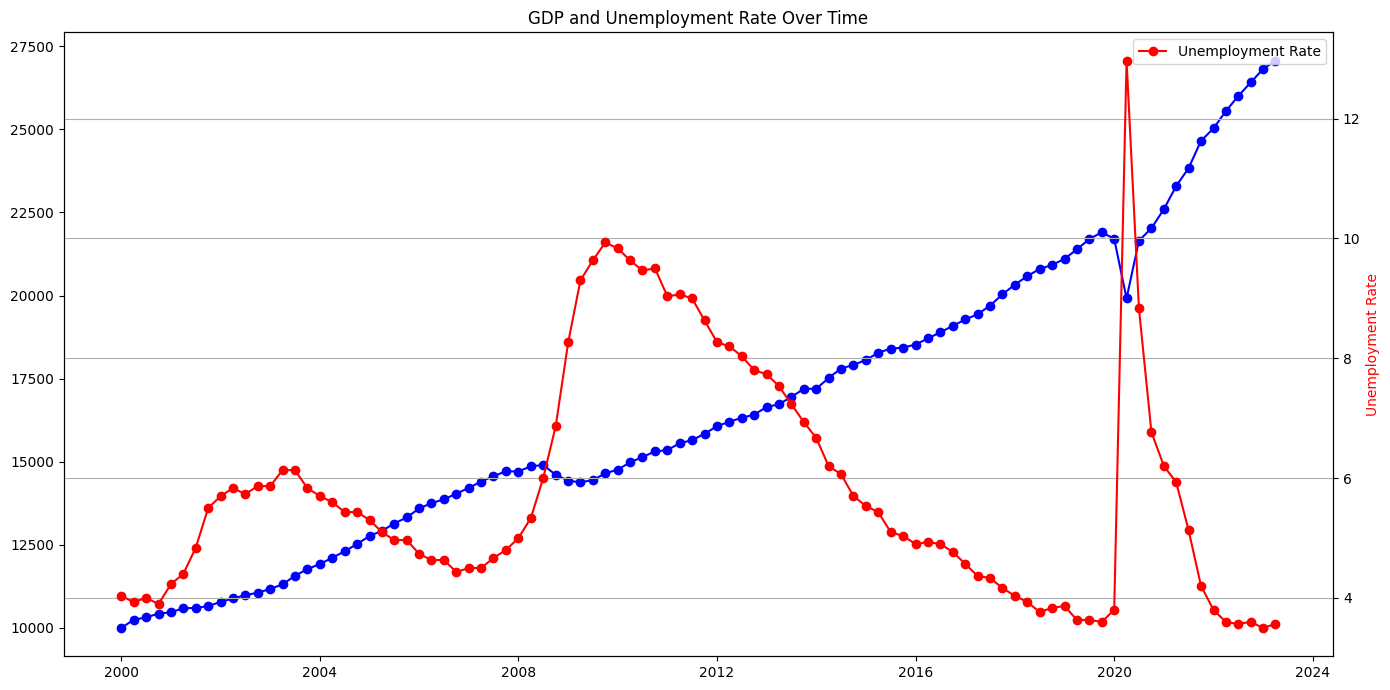

In [92]:
# Charting the Economic Indicators

Economic_Indicators = pd.DataFrame(Economic_Indicators)

# Convert 'DATE' to datetime if it's not already
Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'])

# Filter the DataFrame for years greater than or equal to 2000
Economic_Indicators = Economic_Indicators[Economic_Indicators['Date'].dt.year >= 2000]

# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size

# Plot GDP
plt.plot(Economic_Indicators['Date'], Economic_Indicators['GDP'], label='GDP', marker='o', color='blue')

# Plot Unemployment Rate on a secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(Economic_Indicators['Date'], Economic_Indicators['Unemployment_rate'], label='Unemployment Rate', marker='o', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('GDP', color='blue')
ax2.set_ylabel('Unemployment Rate', color='red')
plt.title('GDP and Unemployment Rate Over Time')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show a grid
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

# Final Table name is <span style="color:red">Economic_Indicators</span>

--------

# 3. Loading and Modeling all IMDB datasets

<a name="_page0_x69.69_y423.22"></a>**IMDb Dataset Legend**

<Details>

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows:

<a name="_page0_x60.71_y555.04"></a>**title.akas.tsv.gz**

- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title <a name="_page1_x60.71_y183.54"></a>**title.basics.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.002.png) endYear (YYYY) – TV Series end year. ‘\N’ for all other title types ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.003.png) runtimeMinutes – primary runtime of the title, in minutes ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.004.png) genres (string array) – includes up to three genres associated with the title

<a name="_page1_x60.71_y549.05"></a>**title.crew.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- directors (array of nconsts) - director(s) of the given title
- writers (array of nconsts) – writer(s) of the given title

<a name="_page1_x60.71_y680.87"></a>**title.episode.tsv.gz**

- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series

<a name="_page2_x60.71_y99.65"></a>**title.principals.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) - alphanumeric unique identifier of the name/person
- category (string) - the category of job that person was in
- job (string) - the specific job title if applicable, else '\N'
- characters (string) - the name of the character played if applicable, else '\N'

<a name="_page2_x60.71_y321.35"></a>**title.ratings.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

<a name="_page2_x60.71_y453.18"></a>**name.basics.tsv.gz**

- nconst (string) - alphanumeric unique identifier of the name/person
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for



In [19]:
# IMDB Data -- More about the dataset below in markdown

IMDb_Basics = pd.read_csv('IMDb Basics.tsv', sep='\t')
IMDb_Ratings = pd.read_csv('IMDb Ratings.tsv', sep='\t')
IMDb_Title_Akas = pd.read_csv('IMDb Title Akas.tsv', sep='\t')
# IMDb_Name_Basics = pd.read_csv('IMDb Name Basics.tsv', sep='\t')
# IMDb_Title_Crew = pd.read_csv('IMDb Title Crew.tsv', sep='\t')
# Title_Episode = pd.read_csv('Title Episode.tsv', sep='\t')
# Title_Principals = pd.read_csv('Title Principals.tsv', sep='\t')

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_65916/2113775829.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_Basics = pd.read_csv('IMDb Basics.tsv', sep='\t')
/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_65916/2113775829.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_Title_Akas = pd.read_csv('IMDb Title Akas.tsv', sep='\t')


### 1. Cleaning IMDB_Basics
-----------

In [20]:
# Converting the data to different data types

IMDb_Basics['tconst'] = IMDb_Basics['tconst'].astype(str)
IMDb_Basics['primaryTitle'] = IMDb_Basics['primaryTitle'].astype(str)
IMDb_Basics['originalTitle'] = IMDb_Basics['originalTitle'].astype(str)
IMDb_Basics['isAdult'] = IMDb_Basics['isAdult'].astype(bool)

# Handle 'startYear'
IMDb_Basics['startYear'] = IMDb_Basics['startYear'].replace('\\N', np.nan)
IMDb_Basics['startYear'] = IMDb_Basics['startYear'].astype('float').astype('Int64')

# Handle 'endYear'
IMDb_Basics['endYear'] = IMDb_Basics['endYear'].replace('\\N', np.nan)
IMDb_Basics['endYear'] = IMDb_Basics['endYear'].astype('float').astype('Int64')

IMDb_Basics['runtimeMinutes'] = IMDb_Basics['runtimeMinutes'].astype(str)
IMDb_Basics['genres'] = IMDb_Basics['genres'].astype(str)

In [21]:
print(IMDb_Basics.dtypes)

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult             bool
startYear          Int64
endYear            Int64
runtimeMinutes    object
genres            object
dtype: object


In [22]:
# This code will display all the unique types of titles present in the titleType column of your DataFrame.
unique_title_types = IMDb_Basics['titleType'].unique()
print(unique_title_types)

['short' 'movie' 'tvShort' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'tvPilot']


In [23]:
# Filtering DataFrame for rows where titleType is exactly 'Movie'
IMDb_Basics = IMDb_Basics[IMDb_Basics['titleType'] == 'movie']

In [24]:
IMDb_Basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,<NA>,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,False,1905,<NA>,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,<NA>,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,False,1907,<NA>,90,Drama


### 2. Cleaning IMDB_name_Basic
-----------

In [25]:
# # Inspecting how the df looks.
# IMDb_Name_Basics.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0031983,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0049189,tt0054452,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0080455,tt0077975,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0069467"


In [26]:
# # Inspecting the data types
# print(IMDb_Name_Basics.dtypes)

nconst               object
primaryName          object
birthYear            object
deathYear            object
primaryProfession    object
knownForTitles       object
dtype: object


In [27]:
# # Convert string columns
# IMDb_Name_Basics['nconst'] = IMDb_Name_Basics['nconst'].astype(str)
# IMDb_Name_Basics['primaryName'] = IMDb_Name_Basics['primaryName'].astype(str)
# IMDb_Name_Basics['primaryProfession'] = IMDb_Name_Basics['primaryProfession'].astype(str)
# IMDb_Name_Basics['knownForTitles'] = IMDb_Name_Basics['knownForTitles'].astype(str)

# # Convert birthYear and deathYear to integer (with NA support)
# # First, replace '\N' with NaN
# IMDb_Name_Basics['birthYear'].replace('\\N', pd.NA, inplace=True)
# IMDb_Name_Basics['deathYear'].replace('\\N', pd.NA, inplace=True)

# # Convert to Int64 (capital "I" to support NaN)
# IMDb_Name_Basics['birthYear'] = IMDb_Name_Basics['birthYear'].astype('Int64')
# IMDb_Name_Basics['deathYear'] = IMDb_Name_Basics['deathYear'].astype('Int64')

In [28]:
# # Finally looking at the changed data types
# print(IMDb_Name_Basics.dtypes)

nconst               object
primaryName          object
birthYear             Int64
deathYear             Int64
primaryProfession    object
knownForTitles       object
dtype: object


### 3. Cleaning IMDb_Ratings DF
------------

In [29]:
IMDb_Ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2002
1,tt0000002,5.8,269
2,tt0000003,6.5,1892
3,tt0000004,5.5,178
4,tt0000005,6.2,2679


In [30]:
# Inspecting the data types
IMDb_Ratings.dtypes

tconst            object
averageRating    float64
numVotes           int64
dtype: object

### 4. Cleaning IMDb_Title_Akas
-----------

In [31]:
IMDb_Title_Akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [32]:
IMDb_Title_Akas.dtypes

titleId            object
ordering            int64
title              object
region             object
language           object
types              object
attributes         object
isOriginalTitle    object
dtype: object

### 5. Cleaning IMDb_Title_Crew
-----------

In [33]:
# IMDb_Title_Crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [34]:
# IMDb_Title_Crew.dtypes

tconst       object
directors    object
writers      object
dtype: object

### 6. Cleaning IMDb_Episode
-----------

In [35]:
# Title_Episode.head(20)

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1,9
1,tt0042816,tt0989125,1,17
2,tt0042889,tt0989125,\N,\N
3,tt0043426,tt0040051,3,42
4,tt0043631,tt0989125,2,16
5,tt0043693,tt0989125,2,8
6,tt0043710,tt0989125,3,3
7,tt0044093,tt0959862,1,6
8,tt0044668,tt0044243,2,16
9,tt0044901,tt0989125,3,46


### 7. Cleaning IMDb_Principals
-----------

In [36]:
# Title_Principals.head(20)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
5,tt0000003,1,nm0721526,director,\N,\N
6,tt0000003,2,nm1770680,producer,producer,\N
7,tt0000003,3,nm1335271,composer,\N,\N
8,tt0000003,4,nm5442200,editor,\N,\N
9,tt0000004,1,nm0721526,director,\N,\N


## Merging all IMDb Datasets

In [41]:
# Merge datasets based on 'tconst'
merged_data = IMDb_Basics.merge(IMDb_Ratings, on='tconst', how='left')
# merged_data = merged_data.merge(Title_Principals, on='tconst', how='left')

# Merge with IMDb_Title_Akas
merged_data = merged_data.merge(IMDb_Title_Akas, left_on='tconst', right_on='titleId', how='left')

In [42]:
merged_data.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance,5.3,207.0,tt0000009,1.0,Miss Jerry,\N,\N,original,\N,1
1,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance,5.3,207.0,tt0000009,2.0,Miss Jerry,AU,\N,imdbDisplay,\N,0
2,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance,5.3,207.0,tt0000009,3.0,Fräulein Jerry,DE,\N,\N,literal title,0
3,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance,5.3,207.0,tt0000009,4.0,Miss Jerry,HU,\N,imdbDisplay,\N,0
4,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance,5.3,207.0,tt0000009,5.0,Miss Jerry,US,\N,imdbDisplay,\N,0


# 4. Loading and Modeling Movie Revenue dataset

In [38]:
# 4: Gross Movie revenue data
# Function to try multiple date formats
def parse_dates(date):
    for fmt in ('%d-%b', '%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y'):  # Add or modify formats as needed
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    # Return the original date if no format matched
    return pd.NaT

# Path to the directory where all your CSV files are stored
path_to_files = '/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/MSEA/ECON 5813 - Economic Analytics I/Project Proposal/Data/Gross Data/'

# Use glob to match the pattern for all CSV files. The * wildcard will match any characters
file_pattern = path_to_files + '/* *.csv'
file_list = glob.glob(file_pattern)

# Create an empty list to hold your dataframes
dataframes_list = []

# Loop over the list of file paths & names
for file_name in file_list:
    # Read the current file into a dataframe
    df = pd.read_csv(file_name)
    
    # Extract month and year from the filename to create a new 'Date' column if needed
    # This can help if the 'Release Date' column isn't consistent
    month_year = file_name.split('/')[-1].replace('.csv', '')
    try:
        # Trying to convert 'month year' to a datetime object, assuming format 'Month YYYY'
        df['Date'] = datetime.strptime(month_year, '%B %Y')
    except ValueError:
        print(f"Skipping file {file_name}: Date format issue")
        continue
    
    # Append the dataframe to the list
    dataframes_list.append(df)

# Combine all dataframes into one
Movie_Revenues = pd.concat(dataframes_list, ignore_index=True)

# Apply the custom date parser to the 'Release Date' column
Movie_Revenues['Release Date'] = Movie_Revenues['Release Date'].apply(parse_dates)

# Now, sort by 'Release Date' if possible, otherwise, by the new 'Date' column
if Movie_Revenues['Release Date'].isnull().all():
    Movie_Revenues = Movie_Revenues.sort_values('Date')
else:
    Movie_Revenues = Movie_Revenues.sort_values('Release Date')

In [39]:
# The Gross Revenue Dataset
Movie_Revenues.head()

,Rank,Release,Gross,Theaters,Total Gross,Release Date,Distributor,Date
7618,115.0,Chimes at Midnight,"$18,111",4,"$126,724",1900-01-01,Janus Films,2016-03-01
7001,115.0,Yosemite,"$11,090",4,"$13,931",1900-01-01,Monterey Media,2016-01-01
6941,59.0,Ho Mann Jahaan,"$201,591",23,"$208,611",1900-01-01,Eros Worldwide,2016-01-01
12413,74.0,Only Yesterday,"$70,884",44,"$453,243",1900-01-01,GKIDS,2016-02-01
6197,122.0,Only Yesterday,"$19,125",44,"$453,243",1900-01-01,GKIDS,2016-04-01


In [52]:
filtered_df = Movie_Revenues[Movie_Revenues['Release'].str.contains('Avengers', case=False, na=False)]
filtered_df.head()

,Rank,Release,Gross,Theaters,Total Gross,Release Date,Distributor,Date
17293,11.0,Avengers: Endgame,"$32,127,101","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-06-01
9795,1.0,Avengers: Endgame,"$427,099,795","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-04-01
95,91.0,Avengers: Endgame,"$71,658","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-09-01
12502,1.0,Avengers: Endgame,"$382,663,001","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-05-01
14034,33.0,Avengers: Endgame,"$1,320,836","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-08-01
